In [23]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd

class FontCharacterDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
        self.label_encoder = LabelEncoder()
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['Font']) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]  
        label = self.data.iloc[idx, 2]

        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [24]:
transformation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [25]:
train_dataset = FontCharacterDataset(csv_file='/kaggle/input/english-fontnumber-recognition/train.csv', transform=transformation)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [26]:
train_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 59)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 62)  # 62 classes (26 uppercase, 26 lowercase, 10 digits)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 6 * 6)  # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("Training completed.")

[Epoch 1, Batch 100] loss: 1.0006
[Epoch 1, Batch 200] loss: 0.8363
[Epoch 1, Batch 300] loss: 0.7853
[Epoch 1, Batch 400] loss: 0.7015
[Epoch 1, Batch 500] loss: 0.6514
[Epoch 1, Batch 600] loss: 0.6427
[Epoch 1, Batch 700] loss: 0.5879
[Epoch 1, Batch 800] loss: 0.5944
[Epoch 1, Batch 900] loss: 0.5990
[Epoch 1, Batch 1000] loss: 0.5659
[Epoch 1, Batch 1100] loss: 0.5400
[Epoch 1, Batch 1200] loss: 0.5163
[Epoch 1, Batch 1300] loss: 0.5250
[Epoch 1, Batch 1400] loss: 0.4993
[Epoch 1, Batch 1500] loss: 0.4957
[Epoch 1, Batch 1600] loss: 0.4748
[Epoch 1, Batch 1700] loss: 0.4753
[Epoch 1, Batch 1800] loss: 0.4330
[Epoch 1, Batch 1900] loss: 0.4569
[Epoch 2, Batch 100] loss: 0.3921
[Epoch 2, Batch 200] loss: 0.4149
[Epoch 2, Batch 300] loss: 0.3843
[Epoch 2, Batch 400] loss: 0.4148
[Epoch 2, Batch 500] loss: 0.4055
[Epoch 2, Batch 600] loss: 0.3822
[Epoch 2, Batch 700] loss: 0.3917
[Epoch 2, Batch 800] loss: 0.3826
[Epoch 2, Batch 900] loss: 0.3722
[Epoch 2, Batch 1000] loss: 0.3773
[Ep

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to make predictions and visualize the results
def visualize_predictions(model, dataset, label_encoder, num_images=5):
    model.eval()
    
    random_indices = random.sample(range(len(dataset)), num_images)
    
    plt.figure(figsize=(10, num_images * 2))
    
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            image, true_label = dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            output = model(image)
            _, predicted_label = torch.max(output.data, 1)
            
            predicted_font = label_encoder.inverse_transform([predicted_label.item()])[0]
            true_font = label_encoder.inverse_transform([true_label])[0]
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image.cpu().squeeze(), cmap='gray')
            plt.title(f"Pred: {predicted_font}\nTrue: {true_font}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


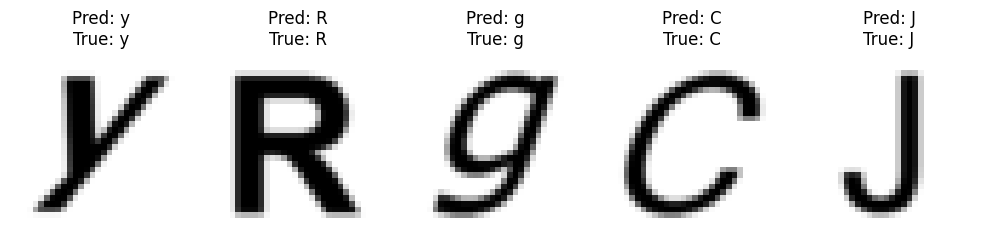

In [34]:
visualize_predictions(model, train_dataset, train_dataset.label_encoder, num_images=5)